In [1]:
# Atrous convolutions for fun and profit. OK maybe just for fun.


# numpy implementation
import numpy as np
import matplotlib.pyplot as plt

# load input data (we will train the network as a shallow autoencoder for starters)


# parameters
hSize = 64
kernSize = 3 # kernels are 3x3 


# initialize the weights

# forward pass

# back prop



In [2]:
# Tensorflow implementation

# imports 
import numpy as np
# Used for reading in images
import cv2
import scipy.misc as misc
# used for timing 
import time

# tensorflow imports for flowing those tensors
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt


/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:

# hyperparameters
mySeed = 1337

dispIt = 40
maxSteps = 200
dORate = 0.4
batchSize = 4
lR = 3e-4
# number of kernels per layer
convDepth = 4
myBias = 0#1.0
#dimX = 482
#dimY = 646
# Image characteristics
dimY = 1344#imgWidth
dimX = 1024#imgHeight
myChan = 1
myOutChan = 1
# ***
pool1Size = 1#2   
pool2Size = 1
kern1Size = 3
kern2Size = 3


data = tf.placeholder("float",[None, dimX,dimY,myChan], name='X')

learningRate = tf.placeholder("float",name='learningRate')

mode = tf.placeholder("bool",name="myMode")

# Define atrous conv filtes
a1Filters = tf.Variable(tf.random_normal([3, 3,convDepth,convDepth], stddev=0.35),name="a1weights")
a2Filters = tf.Variable(tf.random_normal([3, 3,convDepth,convDepth], stddev=0.35),name="a2weights")
a4Filters = tf.Variable(tf.random_normal([3, 3,convDepth,convDepth], stddev=0.35),name="a4weights")
a8Filters = tf.Variable(tf.random_normal([3, 3,convDepth,convDepth], stddev=0.35),name="a8weights")



In [4]:

def atrousCNN(data,mode):
	# mode = false apply dropout
	# mode = true don't apply dropout, i.e. for evaluation/test
	
	inputLayer = tf.reshape(data,[-1,dimX,dimY,myChan])
	
	"""Layer 0"""
	conv0 = tf.layers.conv2d(
		inputs = inputLayer,
		filters = convDepth,
		kernel_size = [kern1Size,kern1Size],
		padding = "same",
		activation = tf.nn.relu, use_bias = True, bias_initializer = tf.constant_initializer(myBias),name = "conv0")
	dropout0 = tf.layers.dropout(
	    inputs = conv0,#conv1,
	    rate = dORate,
	    training = mode,
	    name = "dropout0")#128x16

	"""Layer 1"""
	conv1 = tf.layers.conv2d(
		inputs = dropout0,
		filters = convDepth,
		kernel_size = [kern1Size,kern1Size],
		padding = "same",
		activation = tf.nn.relu, use_bias = True, bias_initializer = tf.constant_initializer(myBias),name = "conv1")
	dropout1 = tf.layers.dropout(
	    inputs = conv1,#conv1,
	    rate = dORate,
	    training = mode,
	    name = "dropout1")#128x16

	"""Layer 2"""
	conv2 = tf.layers.conv2d(
		inputs = dropout1,
		filters = convDepth,
		kernel_size = [kern1Size,kern1Size],
		padding = "same",
		activation = tf.nn.relu, use_bias = True, bias_initializer = tf.constant_initializer(myBias),name = "conv2")
	dropout2 = tf.layers.dropout(
	    inputs = conv2,#conv1,
	    rate = dORate,
	    training = mode,
	    name = "dropout2")#128x16

	"""Parallel atrous convolutions"""
	atrous1 = tf.nn.relu(tf.nn.atrous_conv2d(dropout2,a1Filters,1,"SAME",name='atrous1'))
	atrous2 = tf.nn.relu(tf.nn.atrous_conv2d(dropout2,a2Filters,2,"SAME",name='atrous2'))
	atrous4 = tf.nn.relu(tf.nn.atrous_conv2d(dropout2,a4Filters,4,"SAME",name='atrous4'))
	atrous8 = tf.nn.relu(tf.nn.atrous_conv2d(dropout2,a8Filters,8,"SAME",name='atrous8'))
	
	dropout3_5 = tf.layers.dropout(
		inputs = tf.concat([atrous1,atrous2,atrous4,atrous8],3),
#([atrous1,atrous2,atrous3,atrous4,atrous5,atrous6,atrous7,atrous8,atrous9,atrous10],3),
		rate = dORate,
		training = mode,
		name = "dropout3_5")
	conv4 = tf.layers.conv2d(
		inputs = dropout3_5,
		filters = convDepth,
		kernel_size = [kern1Size,kern1Size],
		padding = "same",
		activation = tf.nn.relu, 
		use_bias = True, 
		bias_initializer = tf.constant_initializer(myBias),name = "conv4")
    
	dropout4 = tf.layers.dropout(
		inputs = tf.concat([atrous1,atrous2,atrous4,atrous8],3),
#([atrous1,atrous2,atrous3,atrous4,atrous5,atrous6,atrous7,atrous8,atrous9,atrous10],3),
		rate = dORate,
		training = mode,
		name = "dropout4")
	
	conv5 = tf.layers.conv2d(
		inputs = dropout4,
		filters = 1,#convDepth,
		kernel_size = [kern1Size,kern1Size],
		padding = "same",
		activation = tf.nn.relu, 
		use_bias = True, 
		bias_initializer = tf.constant_initializer(myBias),name = "conv5")
	myOutput = conv5
	return myOutput


In [5]:
myOut = atrousCNN(data,mode)

print("output shape",np.shape(myOut))	

# operating in autoencoder mode
loss = tf.sqrt(tf.reduce_mean(tf.pow(data - myOut, 2)))

#loss = tf.reduce_mean(targets - myOut)
trainOp = tf.train.AdamOptimizer(
	learning_rate=lR,beta1=0.9,
	beta2 = 0.999,
	epsilon=1e-08,
	use_locking=False,
	name='Adam').minimize(loss,global_step = tf.contrib.framework.get_global_step())


output shape (?, 1024, 1344, 1)
Instructions for updating:
Please switch to tf.train.get_global_step


Epoch 0 training loss: 1.2356e-01 


<Figure size 432x288 with 0 Axes>

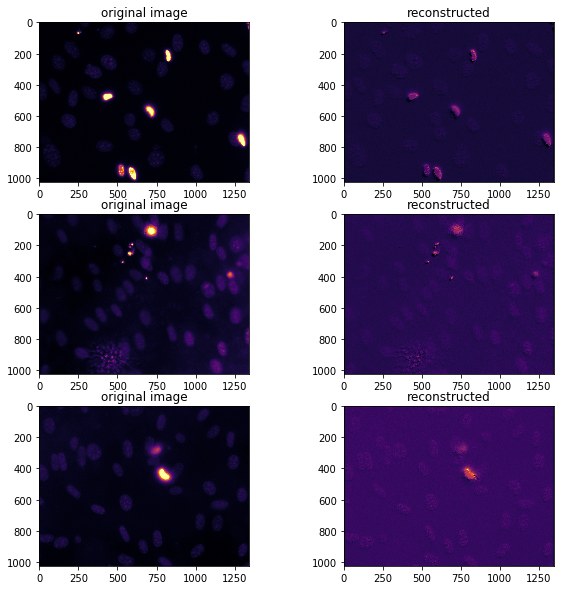

Epoch 40 training loss: 7.0463e-02 


<Figure size 432x288 with 0 Axes>

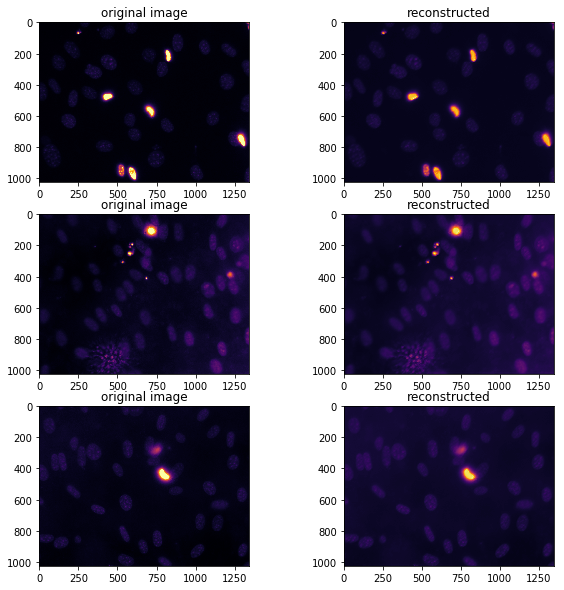

In [ ]:

init = tf.global_variables_initializer()
def main(unused_argv):
    #tf.reset_default_graph()
    with tf.Session() as sess: 
        #tf.initialize_all_variables().run() 
        sess.run(init)
        lR = 3e-5
        myX = np.load('./coelhoData.npy')
        myMin = np.min(myX)

        myMax = np.max(myX-myMin)
        myX = (myX-myMin)/(myMax)
        myX = np.reshape(myX, (myX.shape[0],myX.shape[1],myX.shape[2],1))

        for i in range(maxSteps):
            for ck in range(0,len(myX),batchSize):
                input_ = myX[ck:ck+batchSize]

                sess.run(trainOp, feed_dict = {data: input_, learningRate: lR, mode: True})

            if(i% dispIt ==0):
                inp = tf.placeholder(tf.float32)

                myMean = tf.reduce_mean(inp)
                myTemp = (sess.run(loss, feed_dict={data: input_, learningRate: lR, mode: False}))
                myLossTrain = myMean.eval(feed_dict={inp: myTemp})
                print("Epoch %i training loss: %.4e "%(i,myLossTrain))

                recon = sess.run(myOut,feed_dict = {data: input_, mode: False})
                #decon = sess.run(myDecon,feed_dict = {data: input_, mode: False})
                plt.figure(figsize=(10,10))
                for ck in range(3):
                    
                    plt.subplot(3,2,ck*2+1)
                    plt.title("original image")
                    plt.imshow(input_[ck,:,:,0],cmap="inferno")
                    plt.subplot(3,2,ck*2+2)
                    plt.title("reconstructed")
                    plt.imshow(recon[ck,:,:,0],cmap="inferno")

                    #plt.subplot(133)
                    #plt.title("pseudo-deconvolved")
                    #plt.imshow(decon[ck,:,:,0],cmap="inferno")

                plt.show()#plt.savefig("./figs/epoch%iImg%i.png"%(i,ck))
                plt.clf()

    print("finished .. . .")


if __name__ == "__main__":
    tf.app.run()

## References
1. 